In [1]:
import requests
import locale
import matplotlib.pyplot as plt
import numpy as np

locale.setlocale(locale.LC_ALL, 'de_DE.utf8')

from sitemap import parse_sitemap
from api import MediaWikiSession, MediaWikiAPI
from cachecontrol import CacheControl

In [16]:
from IPython.display import display, Markdown, HTML

def display_markdown(markdown):
    display(Markdown(markdown))
    
def display_html(html):
    display(HTML(html))
    
def h(title, level=1, hid=None):
    html = "<h" + str(level)
    
    if hid:
        html += " id='" + hid + "'"
    
    html += ">"
    html += title
    html += "</h" + str(level) + ">"
    
    display_html(html)
    
def d(x):
    return locale.format("%9d", x, grouping=True)

def diff(a,b):
    return locale.format("%+9d", a-b, grouping=True)

def quot(a,b):
    if b != 0:
        return "(%+3.0f%%)" % ((a-b)/b*100)
    else:
        return " " * 7

In [3]:
req_session = CacheControl(requests.session())

wb = MediaWikiAPI(MediaWikiSession("de.wikibooks.org", req_session))
wp = MediaWikiAPI(MediaWikiSession("de.wikipedia.org", req_session))

In [19]:
sitemap_code = wb.get_content("Mathe für Nicht-Freaks: Sitemap")
sitemap = parse_sitemap(sitemap_code)
sitemap["name"] = "Mathe für Nicht-Freaks"
sitemap["link"] = "Mathe für Nicht-Freaks"

In [5]:
def node_func(func):
    def result_func(node):
        if "link" in node and node["link"]:
            if id(func) not in node:
                node[id(func)] = func(node["link"])
                
            return node[id(func)]
        else:
            return None
    
    return result_func

def collect(func, node):
    result = func(node)
    if result != None:
        result = [result]
    else:
        result = []
    
    for child in node["children"]:
        result += collect(func, child)
    
    return result

def collect_pd(func, node):
    return pd.Series(collect(func, node))

def wb_views(start, end):
    return node_func(lambda x: wb.pageviews(x,start,end))

In [6]:
views_2016 = wb_views("20160101", "20161231")

views_ws16 = wb_views("20161001", "20170331")
views_ws15 = wb_views("20151001", "20160331")

In [7]:
@node_func
def ws16_diff(link):
    return wb.pageviews(link,"20161001","20170331")-wb.pageviews(link,"20151001","20160331")

In [8]:
def wikipedia_title(x):
    params = {
        "action":"wbgetentities",
        "sites":"dewikibooks",
        "titles":x,
        "props":"sitelinks",
        "languages":"nn",
        "format":"json"
    }
    
    result = req_session.get("http://wikidata.org/w/api.php", params=params).json()["entities"]
    key, value = result.popitem()
    
    if key == "-1":
        return None
    else:
        value = value["sitelinks"]
        
        if "dewiki" in value:
            return value["dewiki"]["title"]
        else:
            return None
        
wp_title = node_func(wikipedia_title)
        
def wp_views(start, end):
    def func(link):
        res = wikipedia_title(link)
        if res != None:
            return wp.pageviews(res,start,end)
        else:
            return 0
    return node_func(func)

def wp_views_quot(start, end):
    def func(link):
        res = wikipedia_title(link)
        if res != None:
            return wb.pageviews(link,start,end) / wp.pageviews(res,start,end)
        else:
            return 0
    return node_func(func)
        
wp_ws16 = wp_views("20161001", "20170331")
wp_ws15 = wp_views("20151001", "20160331")

wp_ws16_quot = wp_views_quot("20161001", "20170331")
wp_ws15_quot = wp_views_quot("20151001", "20160331")

In [14]:
def toc(node, level=0):
    result = (" " * level * 4) + ("* [%s](#%s)\n" % (node["name"], node["name"]))
    
    for child in node["children"]:
        result += toc(child, level+1)
    
    return result

h("Inhaltsverzeichnis",1,hid="Inhaltsverzeichnis")

display_markdown(toc(sitemap))

* [Mathe für Nicht-Freaks](#Mathe für Nicht-Freaks)
    * [Grundlagen der Mathematik](#Grundlagen der Mathematik)
        * [Was ist Mathematik?](#Was ist Mathematik?)
            * [Was ist Mathematik?](#Was ist Mathematik?)
            * [Teilgebiete der Mathematik](#Teilgebiete der Mathematik)
        * [Einführung in die Logik](#Einführung in die Logik)
            * [Aussagenlogik](#Aussagenlogik)
            * [Junktoren](#Junktoren)
            * [Notwendige und hinreichende Bedingungen](#Notwendige und hinreichende Bedingungen)
            * [Wahrheitstabelle](#Wahrheitstabelle)
            * [Quantoren](#Quantoren)
            * [Aussageform und Substitution](#Aussageform und Substitution)
            * [Tautologien](#Tautologien)
            * [Aussagen formalisieren](#Aussagen formalisieren)
            * [Aussagen negieren](#Aussagen negieren)
            * [Gesetze der Logik](#Gesetze der Logik)
            * [Aufgaben](#Aufgaben)
        * [Beweise und Beweismethoden](#Beweise und Beweismethoden)
            * [Was sind Beweise?](#Was sind Beweise?)
            * [Direkter und indirekter Beweis](#Direkter und indirekter Beweis)
            * [Fallunterscheidung und Kontraposition](#Fallunterscheidung und Kontraposition)
        * [Vollständige Induktion](#Vollständige Induktion)
            * [Definition und Erklärung](#Definition und Erklärung)
            * [Beispielaufgaben](#Beispielaufgaben)
        * [Mengenlehre](#Mengenlehre)
            * [Definition einer Menge](#Definition einer Menge)
            * [Mengenschreibweisen](#Mengenschreibweisen)
            * [Russells Antinomie](#Russells Antinomie)
            * [Euler- und Venn-Diagramme](#Euler- und Venn-Diagramme)
            * [Teilmenge und echte Teilmenge](#Teilmenge und echte Teilmenge)
            * [Potenzmenge](#Potenzmenge)
            * [Leere Menge](#Leere Menge)
            * [Disjunkte Mengen](#Disjunkte Mengen)
            * [Mengenverknüpfungen](#Mengenverknüpfungen)
            * [Durchschnitt von Mengen](#Durchschnitt von Mengen)
            * [Vereinigung von Mengen](#Vereinigung von Mengen)
            * [Differenz, symmetrische Differenz und Komplement](#Differenz, symmetrische Differenz und Komplement)
            * [Tupel und geordnetes Paar](#Tupel und geordnetes Paar)
            * [Kartesisches Produkt](#Kartesisches Produkt)
            * [Formeln der Mengenlehre](#Formeln der Mengenlehre)
            * [Mengengleichungen beweisen](#Mengengleichungen beweisen)
        * [Relationen](#Relationen)
            * [Relationen](#Relationen)
            * [Binäre Relationen](#Binäre Relationen)
            * [Eigenschaften binärer Relationen](#Eigenschaften binärer Relationen)
            * [Äquivalenzrelationen](#Äquivalenzrelationen)
            * [Ordnungsrelationen](#Ordnungsrelationen)
            * [Ordnungsrelationen: Aufgaben](#Ordnungsrelationen: Aufgaben)
        * [Abbildungen](#Abbildungen)
            * [Abbildungen](#Abbildungen)
            * [Verknüpfungen](#Verknüpfungen)
        * [Mächtigkeit von Mengen](#Mächtigkeit von Mengen)
            * [Mächtigkeit von Mengen](#Mächtigkeit von Mengen)
        * [Gleichungsumformungen](#Gleichungsumformungen)
            * [Gleichungsumformungen](#Gleichungsumformungen)
            * [Termumformungen](#Termumformungen)
            * [Aufgaben](#Aufgaben)
        * [Summe, Produkt und Fakultät](#Summe, Produkt und Fakultät)
            * [Summe und Produkt](#Summe und Produkt)
            * [Gaußsche Summenformel](#Gaußsche Summenformel)
            * [Geometrische Summenformel](#Geometrische Summenformel)
            * [Eigenschaften für Summe und Produkt](#Eigenschaften für Summe und Produkt)
            * [Fakultät](#Fakultät)
        * [Binomialkoeffizient](#Binomialkoeffizient)
            * [Binomialkoeffizient](#Binomialkoeffizient)
            * [Der binomische Lehrsatz](#Der binomische Lehrsatz)
            * [Rechenregeln](#Rechenregeln)
        * [Anhang](#Anhang)
            * [Wörterbuch mathematischer Begriffe](#Wörterbuch mathematischer Begriffe)
            * [Liste mathematischer Symbole](#Liste mathematischer Symbole)
            * [Zusammenfassung](#Zusammenfassung)
            * [PDF-Version (Beta)](#PDF-Version (Beta))
    * [Analysis 1](#Analysis 1)
        * [Was ist Analysis?](#Was ist Analysis?)
            * [Was ist Analysis?](#Was ist Analysis?)
            * [Wozu Analysis studieren?](#Wozu Analysis studieren?)
        * [Was sind reelle Zahlen?](#Was sind reelle Zahlen?)
            * [Was sind reelle Zahlen?](#Was sind reelle Zahlen?)
            * [Die Zahlengerade](#Die Zahlengerade)
        * [Körperaxiome](#Körperaxiome)
            * [Körperaxiome](#Körperaxiome)
            * [Folgerungen der Körperaxiome](#Folgerungen der Körperaxiome)
            * [Potenzen reeller Zahlen](#Potenzen reeller Zahlen)
        * [Anordnungsaxiome](#Anordnungsaxiome)
            * [Anordnungsaxiome](#Anordnungsaxiome)
            * [Folgerungen der Anordnungsaxiome](#Folgerungen der Anordnungsaxiome)
            * [Betragsfunktion, Maximum und Minimum](#Betragsfunktion, Maximum und Minimum)
            * [Intervalle](#Intervalle)
        * [Vollständigkeit reeller Zahlen](#Vollständigkeit reeller Zahlen)
            * [Intervallschachtelung mit rationaler Genauigkeit](#Intervallschachtelung mit rationaler Genauigkeit)
            * [Das archimedische Axiom](#Das archimedische Axiom)
            * [Bernoullische Ungleichung](#Bernoullische Ungleichung)
            * [Allgemeine Intervallschachtelungen](#Allgemeine Intervallschachtelungen)
        * [Die komplexen Zahlen](#Die komplexen Zahlen)
            * [Einleitung und Motivation](#Einleitung und Motivation)
            * [Intuition](#Intuition)
            * [Definition](#Definition)
            * [Eigenschaften](#Eigenschaften)
            * [Polardarstellung](#Polardarstellung)
            * [Darstellung komplexwertiger Funktionen](#Darstellung komplexwertiger Funktionen)
            * [Definition und Eigenschaften](#Definition und Eigenschaften)
            * [Aufgaben](#Aufgaben)
        * [Supremum und Infimum](#Supremum und Infimum)
            * [Supremum und Infimum](#Supremum und Infimum)
            * [Uneigentliches Supremum und Infimum](#Uneigentliches Supremum und Infimum)
            * [Supremum und Infimum bestimmen und beweisen](#Supremum und Infimum bestimmen und beweisen)
            * [Eigenschaften Supremum und Infimum](#Eigenschaften Supremum und Infimum)
        * [Wurzel reeller Zahlen](#Wurzel reeller Zahlen)
            * [Wurzel reeller Zahlen](#Wurzel reeller Zahlen)
            * [Lösungen von Potenzgleichungen](#Lösungen von Potenzgleichungen)
            * [Rechenregeln](#Rechenregeln)
            * [Verallgemeinerte Potenzen](#Verallgemeinerte Potenzen)
            * [Aufgaben](#Aufgaben)
        * [Folgen](#Folgen)
            * [Definition](#Definition)
            * [Explizite und rekursive Bildungsgesetze](#Explizite und rekursive Bildungsgesetze)
            * [Beispiele und Eigenschaften](#Beispiele und Eigenschaften)
            * [Aufgaben](#Aufgaben)
        * [Konvergenz und Divergenz](#Konvergenz und Divergenz)
            * [Definition Grenzwert](#Definition Grenzwert)
            * [Konvergenz und Divergenz beweisen](#Konvergenz und Divergenz beweisen)
            * [Beispiele für Grenzwerte](#Beispiele für Grenzwerte)
            * [Unbeschränkte Folgen divergieren](#Unbeschränkte Folgen divergieren)
            * [Grenzwertsätze](#Grenzwertsätze)
            * [Der Sandwichsatz](#Der Sandwichsatz)
            * [Monotoniekriterium](#Monotoniekriterium)
            * [Konvergenzbeweise rekursiver Folgen](#Konvergenzbeweise rekursiver Folgen)
            * [Aufgaben](#Aufgaben)
        * [Teilfolgen, Häufungspunkte und Cauchy-Folgen](#Teilfolgen, Häufungspunkte und Cauchy-Folgen)
            * [Teilfolgen](#Teilfolgen)
            * [Häufungspunkte von Folge](#Häufungspunkte von Folge)
            * [Häufungs- und Berührpunkte von Mengen](#Häufungs- und Berührpunkte von Mengen)
            * [Satz von Bolzano-Weierstraß](#Satz von Bolzano-Weierstraß)
            * [Bestimmte Divergenz](#Bestimmte Divergenz)
            * [Bestimmte Divergenz: Regeln](#Bestimmte Divergenz: Regeln)
            * [Lim sup und Lim inf](#Lim sup und Lim inf)
            * [Cauchy-Folgen](#Cauchy-Folgen)
            * [Aufgaben](#Aufgaben)
        * [Reihen](#Reihen)
            * [Begriff der Reihe](#Begriff der Reihe)
            * [Rechenregeln für Reihen](#Rechenregeln für Reihen)
            * [Teleskopsumme und Teleskopreihe](#Teleskopsumme und Teleskopreihe)
            * [Geometrische Reihe](#Geometrische Reihe)
            * [Harmonische Reihe](#Harmonische Reihe)
            * [e-Reihe](#e-Reihe)
            * [Absolute Konvergenz einer Reihe](#Absolute Konvergenz einer Reihe)
            * [Umordnungssatz für Reihen](#Umordnungssatz für Reihen)
            * [Aufgaben](#Aufgaben)
        * [Konvergenzkriterien für Reihen](#Konvergenzkriterien für Reihen)
            * [Übersicht Konvergenzkriterien](#Übersicht Konvergenzkriterien)
            * [Cauchy-Kriterium](#Cauchy-Kriterium)
            * [Trivialkriterium](#Trivialkriterium)
            * [Beschränkte Reihen und Konvergenz](#Beschränkte Reihen und Konvergenz)
            * [Majoranten- und Minorantenkriterium](#Majoranten- und Minorantenkriterium)
            * [Wurzelkriterium](#Wurzelkriterium)
            * [Quotientenkriterium](#Quotientenkriterium)
            * [Leibniz-Kriterium](#Leibniz-Kriterium)
            * [Verdichtungskriterium](#Verdichtungskriterium)
            * [Anwendung der Konvergenzkriterien](#Anwendung der Konvergenzkriterien)
            * [Aufgaben](#Aufgaben)
        * [Exponential- und Logarithmusfunktion](#Exponential- und Logarithmusfunktion)
            * [Herleitung und Definition der Exponentialfunktion](#Herleitung und Definition der Exponentialfunktion)
            * [Eigenschaften der Exponentialfunktion](#Eigenschaften der Exponentialfunktion)
            * [Logarithmusfunktion](#Logarithmusfunktion)
            * [Verallgemeinerte Potenzen](#Verallgemeinerte Potenzen)
            * [Exponential- und Logarithmusfunktion in den komplexen Zahlen](#Exponential- und Logarithmusfunktion in den komplexen Zahlen)
            * [Aufgaben](#Aufgaben)
        * [Trigonometrische und Hyperbolische Funktionen](#Trigonometrische und Hyperbolische Funktionen)
            * [Sinus und Kosinus](#Sinus und Kosinus)
            * [Eigenschaften des Sinus und Kosinus](#Eigenschaften des Sinus und Kosinus)
            * [Arkussinus und Arkuskosinus](#Arkussinus und Arkuskosinus)
            * [Tangens und Kotangens](#Tangens und Kotangens)
            * [Arkustangens und Arkuskotangens](#Arkustangens und Arkuskotangens)
            * [Sinus Hyperbolicus und Kosinus Hyperbolicus](#Sinus Hyperbolicus und Kosinus Hyperbolicus)
            * [Aufgaben](#Aufgaben)
        * [Stetigkeit](#Stetigkeit)
            * [Stetigkeit von Funktionen](#Stetigkeit von Funktionen)
            * [Folgenkriterium](#Folgenkriterium)
            * [Epsilon-Delta-Kriterium](#Epsilon-Delta-Kriterium)
            * [Grenzwert von Funktionen](#Grenzwert von Funktionen)
            * [Komposition stetiger Funktionen](#Komposition stetiger Funktionen)
            * [Stetigkeit beweisen](#Stetigkeit beweisen)
            * [Unstetigkeit beweisen](#Unstetigkeit beweisen)
            * [Zwischenwertsatz](#Zwischenwertsatz)
            * [Satz vom Minimum und Maximum](#Satz vom Minimum und Maximum)
            * [Stetigkeit der Umkehrfunktion](#Stetigkeit der Umkehrfunktion)
            * [Gleichmäßige Stetigkeit](#Gleichmäßige Stetigkeit)
            * [Lipschitz-Stetigkeit](#Lipschitz-Stetigkeit)
            * [Aufgaben](#Aufgaben)
        * [Ableitung](#Ableitung)
            * [Ableitung](#Ableitung)
            * [Rechengesetze für die Ableitung](#Rechengesetze für die Ableitung)
            * [Ableitung der Umkehrfunktion](#Ableitung der Umkehrfunktion)
            * [Beispiele für Ableitungen](#Beispiele für Ableitungen)
            * [Ableitung höherer Ordnung](#Ableitung höherer Ordnung)
            * [Satz von Rolle](#Satz von Rolle)
            * [Mittelwertsatz](#Mittelwertsatz)
            * [Kriterium für Konstanz und Monotoniekriterium](#Kriterium für Konstanz und Monotoniekriterium)
            * [Ableitung und lokale Extrema](#Ableitung und lokale Extrema)
            * [Regel von L'Hospital](#Regel von L'Hospital)
            * [Aufgaben 1](#Aufgaben 1)
            * [Aufgaben 2](#Aufgaben 2)
            * [Aufgaben 3](#Aufgaben 3)
            * [Aufgaben 4](#Aufgaben 4)
        * [Integrale](#Integrale)
            * [Das Integral](#Das Integral)
            * [Riemann-Integral](#Riemann-Integral)
            * [Eigenschaften des Riemann-Integrals](#Eigenschaften des Riemann-Integrals)
            * [Regelintegral](#Regelintegral)
            * [Mittelwertsatz für Integrale](#Mittelwertsatz für Integrale)
            * [Hauptsatz der Differential- und Integralrechnung](#Hauptsatz der Differential- und Integralrechnung)
            * [Substitutionsregel](#Substitutionsregel)
            * [Partielle Integration](#Partielle Integration)
            * [Beispiele für Integrale](#Beispiele für Integrale)
            * [Aufgaben](#Aufgaben)
        * [Sonstiges](#Sonstiges)
            * [PDF-Version (Beta)](#PDF-Version (Beta))
    * [Lineare Algebra 1](#Lineare Algebra 1)
        * [Einführung](#Einführung)
            * [Was ist lineare Algebra?](#Was ist lineare Algebra?)
            * [Was sind Vektoren?](#Was sind Vektoren?)
            * [Anwendungen der linearen Algebra](#Anwendungen der linearen Algebra)
            * [Geschichte der linearen Algebra](#Geschichte der linearen Algebra)
            * [Eigenschaften des euklidischen Vektorraums](#Eigenschaften des euklidischen Vektorraums)
        * [Vektorräume](#Vektorräume)
            * [Vektorraum](#Vektorraum)
            * [Eigenschaften von Vektorräumen](#Eigenschaften von Vektorräumen)
            * [Der Körper als Vektorraum](#Der Körper als Vektorraum)
            * [Koordinatenräume](#Koordinatenräume)
            * [euklidische Vektorräume](#euklidische Vektorräume)
            * [Folgenräume](#Folgenräume)
            * [Funktionsräume](#Funktionsräume)
            * [Untervektorraum](#Untervektorraum)
            * [Vereinigung und Durchschnitt von Vektorräumen](#Vereinigung und Durchschnitt von Vektorräumen)
            * [Faktorraum](#Faktorraum)
        * [Basis eines Vektorraums](#Basis eines Vektorraums)
            * [Erzeugnis und Erzeugendensystem](#Erzeugnis und Erzeugendensystem)
            * [Lineare Unabhängigkeit von Vektoren](#Lineare Unabhängigkeit von Vektoren)
            * [Basis eines Vektorraums](#Basis eines Vektorraums)
            * [Dimension eines Vektorraums](#Dimension eines Vektorraums)
            * [Summe und direkte Summe ](#Summe und direkte Summe )
        * [Lineare Abbildungen](#Lineare Abbildungen)
            * [Lineare Abbildungen](#Lineare Abbildungen)
            * [Beispiele linearer Abbildungen](#Beispiele linearer Abbildungen)
            * [Eigenschaften linearer Abbildungen](#Eigenschaften linearer Abbildungen)
            * [Prinzip der linearen Fortsetzung](#Prinzip der linearen Fortsetzung)
            * [Arten linearer Abbildungen](#Arten linearer Abbildungen)
            * [Vektorraum linearer Abbildungen](#Vektorraum linearer Abbildungen)
            * [Aufgaben](#Aufgaben)
        * [Matrizen](#Matrizen)
            * [Definition der Matrix](#Definition der Matrix)
            * [Arten von Matrizen](#Arten von Matrizen)
            * [Vektorielle Operationen für Matrizen](#Vektorielle Operationen für Matrizen)
            * [Matrizenmultiplikation](#Matrizenmultiplikation)
            * [Inverse Matrizen](#Inverse Matrizen)
        * [Matrizen als lineare Abbildungen](#Matrizen als lineare Abbildungen)
            * [Lineare Abbildung und darstellende Matrix](#Lineare Abbildung und darstellende Matrix)
            * [Hintereinander Ausführung von linearen Abbildungen](#Hintereinander Ausführung von linearen Abbildungen)
            * [Abbildungsmatrizen](#Abbildungsmatrizen)
            * [Basiswechselmatrizen](#Basiswechselmatrizen)
        * [Isomorphiesatz und Dimensionsformel](#Isomorphiesatz und Dimensionsformel)
            * [Struktur linearer Abbildungen](#Struktur linearer Abbildungen)
            * [Kern einer linearen Abbildung](#Kern einer linearen Abbildung)
            * [Bild einer linearen Abbildung](#Bild einer linearen Abbildung)
            * [Intuition hinter Isomorphiesatz und Dimensionsformel](#Intuition hinter Isomorphiesatz und Dimensionsformel)
            * [Isomorphiesatz](#Isomorphiesatz)
            * [Dimensionsformel](#Dimensionsformel)
        * [Gleichungssysteme und Matrizen](#Gleichungssysteme und Matrizen)
            * [Gleichungssysteme und Matrizen](#Gleichungssysteme und Matrizen)
            * [Matrixform](#Matrixform)
            * [Lösbarkeitskriterien Gleichungssysteme](#Lösbarkeitskriterien Gleichungssysteme)
            * [Lösung von Gleichungssystemen](#Lösung von Gleichungssystemen)
        * [Die Determinante einer Matrix](#Die Determinante einer Matrix)
            * [Determinanten](#Determinanten)
            * [Eigenschaften der Determinante](#Eigenschaften der Determinante)
            * [Determinante für Dreiecksmatrizen](#Determinante für Dreiecksmatrizen)
            * [Adjungierte Matrix](#Adjungierte Matrix)
            * [Cramer'sche Regel](#Cramer'sche Regel)
            * [Leibniz-Formel der Determinante](#Leibniz-Formel der Determinante)
        * [Affine Räume](#Affine Räume)
            * [Affiner Raum in der linearen Algebra](#Affiner Raum in der linearen Algebra)
            * [Affiner Unerraum](#Affiner Unerraum)
            * [Affiner Punkteraum](#Affiner Punkteraum)
            * [Beispiele](#Beispiele)
            * [Affine Abbildungen](#Affine Abbildungen)
    * [Buchanfänge](#Buchanfänge)
        * [Grundlagen der Mathematik](#Grundlagen der Mathematik)
            * [Mengenlehre](#Mengenlehre)
                * [Tupelmodellierung durch Mengen](#Tupelmodellierung durch Mengen)
            * [Mächtigkeit von Mengen](#Mächtigkeit von Mengen)
                * [Hilberts Hotel](#Hilberts Hotel)
        * [Analysis 1](#Analysis 1)
            * [Reihen](#Reihen)
                * [Cauchy-Produkt von Reihen](#Cauchy-Produkt von Reihen)
                * [Summierbare Familien](#Summierbare Familien)
                * [Banachscher Fixpunktsatz](#Banachscher Fixpunktsatz)
            * [Unendliche Produkte](#Unendliche Produkte)
                * [Teleskopprodukte](#Teleskopprodukte)
            * [Taylor- und Potenzreihen](#Taylor- und Potenzreihen)
                * [Aufgaben Taylorreihen](#Aufgaben Taylorreihen)
                * [Aufgaben Potenzreihen](#Aufgaben Potenzreihen)
            * [Differenzierbarkeit](#Differenzierbarkeit)
                * [Konvexe Funktionen und Wendepunkte](#Konvexe Funktionen und Wendepunkte)
            * [Integrale](#Integrale)
                * [Treppenfunktionen](#Treppenfunktionen)
                * [Regelfunktionen und Regelintegral](#Regelfunktionen und Regelintegral)
        * [Algebra](#Algebra)
            * [Auf dem Weg zur Gruppe](#Auf dem Weg zur Gruppe)
            * [Grundlegende Eigenschaften](#Grundlegende Eigenschaften)
            * [Untergruppen und Nebenklassen](#Untergruppen und Nebenklassen)
        * [Gewöhnliche Differentialgleichungen](#Gewöhnliche Differentialgleichungen)
            * [Wozu gewöhnliche Differentialgleichungen?](#Wozu gewöhnliche Differentialgleichungen?)
        * [Abstellraum](#Abstellraum)
            * [Abstellraum](#Abstellraum)
    * [Informationen zum Projekt](#Informationen zum Projekt)
        * [Über das Projekt](#Über das Projekt)
            * [Über das Projekt](#Über das Projekt)
            * [Unterstütze uns!](#Unterstütze uns!)
            * [Kopiere uns!](#Kopiere uns!)
            * [Kontakt](#Kontakt)
            * [Spenden](#Spenden)
            * [Ziele des Projekts](#Ziele des Projekts)
            * [Freie Bildungsmaterialien](#Freie Bildungsmaterialien)
            * [Presse und Blogbeiträge](#Presse und Blogbeiträge)
        * [Hinweise für Autoren und Autorinnen](#Hinweise für Autoren und Autorinnen)
            * [Allgemeine Hinweise](#Allgemeine Hinweise)
            * [Formatierung von Kapiteln](#Formatierung von Kapiteln)
        * [Zusammenarbeit](#Zusammenarbeit)
            * [Aktuelle Aufgaben](#Aktuelle Aufgaben)
            * [Ideen](#Ideen)
            * [Umfragen](#Umfragen)
            * [Sitemap: Übersicht aller Kapitel](#Sitemap: Übersicht aller Kapitel)
            * [Letzte Änderungen am Projekt](#Letzte Änderungen am Projekt)
            * [Projekte und Aktionen](#Projekte und Aktionen)
            * [Protokolle](#Protokolle)
            * [Archiv](#Archiv)


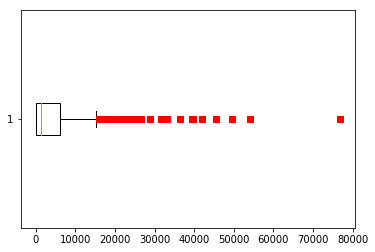

Summe: 1.630.220
Mean:      5.822


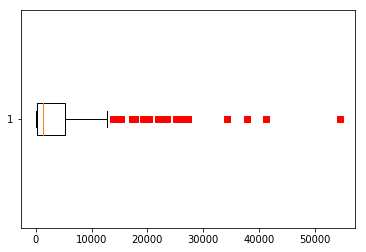

Summe: 1.241.460
Mean:      4.433


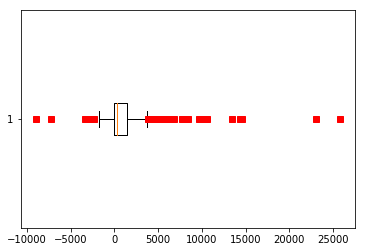

Summe:   357.555
Mean:      1.276


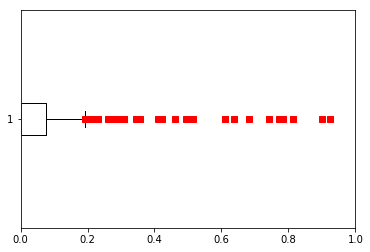

Mean:  19%


2016:          54.029
WiSe 16/17:    34.226 ┬    +2.484 ( +8%)
WiSe 15/16:    31.742 ┘      


Wikipedia-Artikel: Serlo
Views WiSe 16/17:      1.582 ┬      +478 (+43%)
Views WiSe 15/16:      1.104 ┘      

MFNF / Wikipedia – WiSe 16/17: 2163%
MFNF / Wikipedia – WiSe 15/16: 2875%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

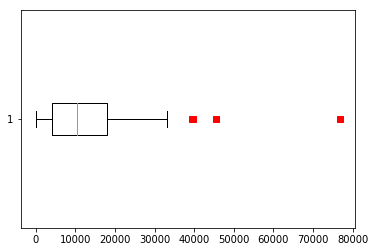

Summe:   805.988
Mean:     13.660


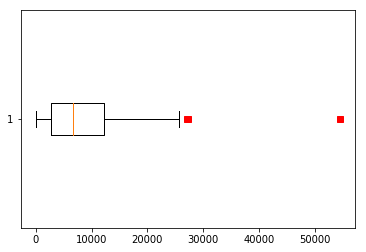

Summe:   544.753
Mean:      9.233


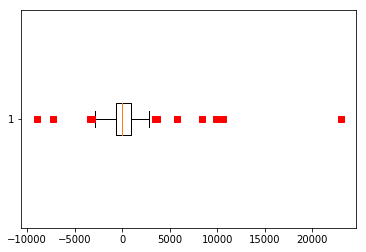

Summe:    38.056
Mean:        645


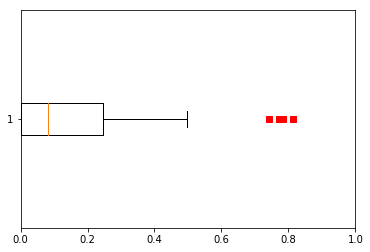

Mean:  28%


2016:          45.572
WiSe 16/17:    27.279 ┬    -3.155 (-10%)
WiSe 15/16:    30.434 ┘      


Wikipedia-Artikel: Grundlagen der Mathematik
Views WiSe 16/17:      4.168 ┬      +170 ( +4%)
Views WiSe 15/16:      3.998 ┘      

MFNF / Wikipedia – WiSe 16/17: 654%
MFNF / Wikipedia – WiSe 15/16: 761%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           5.225
WiSe 16/17:     2.690 ┬      -179 ( -6%)
WiSe 15/16:     2.869 ┘      


Wikipedia-Artikel: Mathematik
Views WiSe 16/17:    121.886 ┬    +4.207 ( +4%)
Views WiSe 15/16:    117.679 ┘      

MFNF / Wikipedia – WiSe 16/17:   2%
MFNF / Wikipedia – WiSe 15/16:   2%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               7
WiSe 16/17:       497 ┬      +497        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Teilgebiete der Mathematik
Views WiSe 16/17:     18.925 ┬      +879 ( +5%)
Views WiSe 15/16:     18.046 ┘      

MFNF / Wikipedia – WiSe 16/17:   3%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          13.090
WiSe 16/17:     7.510 ┬    -1.377 (-15%)
WiSe 15/16:     8.887 ┘      


Wikipedia-Artikel: Aussagenlogik
Views WiSe 16/17:     73.853 ┬    +4.021 ( +6%)
Views WiSe 15/16:     69.832 ┘      

MFNF / Wikipedia – WiSe 16/17:  10%
MFNF / Wikipedia – WiSe 15/16:  13%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          21.300
WiSe 16/17:    12.480 ┬    -2.841 (-19%)
WiSe 15/16:    15.321 ┘      


Wikipedia-Artikel: Junktor
Views WiSe 16/17:     15.311 ┬      -297 ( -2%)
Views WiSe 15/16:     15.608 ┘      

MFNF / Wikipedia – WiSe 16/17:  82%
MFNF / Wikipedia – WiSe 15/16:  98%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           5.002
WiSe 16/17:     3.206 ┬      -123 ( -4%)
WiSe 15/16:     3.329 ┘      


Wikipedia-Artikel: Notwendige und hinreichende Bedingung
Views WiSe 16/17:     47.155 ┬    +4.325 (+10%)
Views WiSe 15/16:     42.830 ┘      

MFNF / Wikipedia – WiSe 16/17:   7%
MFNF / Wikipedia – WiSe 15/16:   8%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          12.370
WiSe 16/17:     8.770 ┬    +1.479 (+20%)
WiSe 15/16:     7.291 ┘      


Wikipedia-Artikel: Wahrheitstabelle
Views WiSe 16/17:     37.747 ┬    +1.854 ( +5%)
Views WiSe 15/16:     35.893 ┘      

MFNF / Wikipedia – WiSe 16/17:  23%
MFNF / Wikipedia – WiSe 15/16:  20%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          23.060
WiSe 16/17:    15.344 ┬    +1.523 (+11%)
WiSe 15/16:    13.821 ┘      


Wikipedia-Artikel: Quantor
Views WiSe 16/17:     30.925 ┬    +3.288 (+12%)
Views WiSe 15/16:     27.637 ┘      

MFNF / Wikipedia – WiSe 16/17:  50%
MFNF / Wikipedia – WiSe 15/16:  50%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           3.120
WiSe 16/17:     1.714 ┬      -342 (-17%)
WiSe 15/16:     2.056 ┘      


Wikipedia-Artikel: Aussageform
Views WiSe 16/17:      2.314 ┬      +145 ( +7%)
Views WiSe 15/16:      2.169 ┘      

MFNF / Wikipedia – WiSe 16/17:  74%
MFNF / Wikipedia – WiSe 15/16:  95%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          10.559
WiSe 16/17:     7.725 ┬      +960 (+14%)
WiSe 15/16:     6.765 ┘      


Wikipedia-Artikel: Tautologie (Logik)
Views WiSe 16/17:     51.885 ┬   -10.232 (-16%)
Views WiSe 15/16:     62.117 ┘      

MFNF / Wikipedia – WiSe 16/17:  15%
MFNF / Wikipedia – WiSe 15/16:  11%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           4.340
WiSe 16/17:     3.066 ┬      +558 (+22%)
WiSe 15/16:     2.508 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          28.804
WiSe 16/17:    25.138 ┬   +10.609 (+73%)
WiSe 15/16:    14.529 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           3.697
WiSe 16/17:     3.329 ┬    +1.560 (+88%)
WiSe 15/16:     1.769 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           2.250
WiSe 16/17:     1.262 ┬      -246 (-16%)
WiSe 15/16:     1.508 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          10.394
WiSe 16/17:     6.345 ┬       +15 ( +0%)
WiSe 15/16:     6.330 ┘      


Wikipedia-Artikel: Beweis (Mathematik)
Views WiSe 16/17:     23.114 ┬      -806 ( -3%)
Views WiSe 15/16:     23.920 ┘      

MFNF / Wikipedia – WiSe 16/17:  27%
MFNF / Wikipedia – WiSe 15/16:  26%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          23.268
WiSe 16/17:    17.479 ┬    +3.676 (+27%)
WiSe 15/16:    13.803 ┘      


Wikipedia-Artikel: Reductio ad absurdum
Views WiSe 16/17:     16.790 ┬    -1.010 ( -6%)
Views WiSe 15/16:     17.800 ┘      

MFNF / Wikipedia – WiSe 16/17: 104%
MFNF / Wikipedia – WiSe 15/16:  78%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           9.850
WiSe 16/17:     6.712 ┬      +212 ( +3%)
WiSe 15/16:     6.500 ┘      


Wikipedia-Artikel: Kontraposition
Views WiSe 16/17:      8.570 ┬      +755 (+10%)
Views WiSe 15/16:      7.815 ┘      

MFNF / Wikipedia – WiSe 16/17:  78%
MFNF / Wikipedia – WiSe 15/16:  83%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          76.878
WiSe 16/17:    54.559 ┬    +1.218 ( +2%)
WiSe 15/16:    53.341 ┘      


Wikipedia-Artikel: Vollständige Induktion
Views WiSe 16/17:     70.702 ┬    -2.570 ( -4%)
Views WiSe 15/16:     73.272 ┘      

MFNF / Wikipedia – WiSe 16/17:  77%
MFNF / Wikipedia – WiSe 15/16:  73%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          32.278
WiSe 16/17:    23.480 ┬    -9.002 (-28%)
WiSe 15/16:    32.482 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          13.417
WiSe 16/17:     7.401 ┬    -3.353 (-31%)
WiSe 15/16:    10.754 ┘      


Wikipedia-Artikel: Mengenlehre
Views WiSe 16/17:     92.578 ┬    -6.841 ( -7%)
Views WiSe 15/16:     99.419 ┘      

MFNF / Wikipedia – WiSe 16/17:   8%
MFNF / Wikipedia – WiSe 15/16:  11%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           8.375
WiSe 16/17:     6.588 ┬    +3.451 (+110%)
WiSe 15/16:     3.137 ┘      


Wikipedia-Artikel: Menge (Mathematik)
Views WiSe 16/17:     81.679 ┬    +7.019 ( +9%)
Views WiSe 15/16:     74.660 ┘      

MFNF / Wikipedia – WiSe 16/17:   8%
MFNF / Wikipedia – WiSe 15/16:   4%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.814
WiSe 16/17:     1.268 ┬      +323 (+34%)
WiSe 15/16:       945 ┘      


Wikipedia-Artikel: Russellsche Antinomie
Views WiSe 16/17:     16.161 ┬    -1.138 ( -7%)
Views WiSe 15/16:     17.299 ┘      

MFNF / Wikipedia – WiSe 16/17:   8%
MFNF / Wikipedia – WiSe 15/16:   5%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           4.406
WiSe 16/17:     2.531 ┬        +9 ( +0%)
WiSe 15/16:     2.522 ┘      


Wikipedia-Artikel: Mengendiagramm
Views WiSe 16/17:     24.449 ┬    -3.313 (-12%)
Views WiSe 15/16:     27.762 ┘      

MFNF / Wikipedia – WiSe 16/17:  10%
MFNF / Wikipedia – WiSe 15/16:   9%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          18.988
WiSe 16/17:    14.729 ┬    +8.398 (+133%)
WiSe 15/16:     6.331 ┘      


Wikipedia-Artikel: Teilmenge
Views WiSe 16/17:     49.634 ┬    +1.282 ( +3%)
Views WiSe 15/16:     48.352 ┘      

MFNF / Wikipedia – WiSe 16/17:  30%
MFNF / Wikipedia – WiSe 15/16:  13%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          10.867
WiSe 16/17:     6.622 ┬    -1.141 (-15%)
WiSe 15/16:     7.763 ┘      


Wikipedia-Artikel: Potenzmenge
Views WiSe 16/17:     41.202 ┬      -682 ( -2%)
Views WiSe 15/16:     41.884 ┘      

MFNF / Wikipedia – WiSe 16/17:  16%
MFNF / Wikipedia – WiSe 15/16:  19%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           5.856
WiSe 16/17:     4.127 ┬      +915 (+28%)
WiSe 15/16:     3.212 ┘      


Wikipedia-Artikel: Leere Menge
Views WiSe 16/17:     29.610 ┬    +1.659 ( +6%)
Views WiSe 15/16:     27.951 ┘      

MFNF / Wikipedia – WiSe 16/17:  14%
MFNF / Wikipedia – WiSe 15/16:  11%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          10.539
WiSe 16/17:     6.395 ┬      -369 ( -5%)
WiSe 15/16:     6.764 ┘      


Wikipedia-Artikel: Disjunkt
Views WiSe 16/17:     29.363 ┬    -9.320 (-24%)
Views WiSe 15/16:     38.683 ┘      

MFNF / Wikipedia – WiSe 16/17:  22%
MFNF / Wikipedia – WiSe 15/16:  17%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          17.079
WiSe 16/17:    10.994 ┬      +229 ( +2%)
WiSe 15/16:    10.765 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           6.321
WiSe 16/17:     4.996 ┬    +2.780 (+125%)
WiSe 15/16:     2.216 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           3.816
WiSe 16/17:     2.929 ┬      +961 (+49%)
WiSe 15/16:     1.968 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           2.343
WiSe 16/17:     1.686 ┬      +190 (+13%)
WiSe 15/16:     1.496 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           6.426
WiSe 16/17:     3.418 ┬      -748 (-18%)
WiSe 15/16:     4.166 ┘      


Wikipedia-Artikel: Tupel
Views WiSe 16/17:     31.793 ┬    -4.104 (-11%)
Views WiSe 15/16:     35.897 ┘      

MFNF / Wikipedia – WiSe 16/17:  11%
MFNF / Wikipedia – WiSe 15/16:  12%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          15.210
WiSe 16/17:     9.778 ┬    -2.779 (-22%)
WiSe 15/16:    12.557 ┘      


Wikipedia-Artikel: Kartesisches Produkt
Views WiSe 16/17:     49.007 ┬    -3.738 ( -7%)
Views WiSe 15/16:     52.745 ┘      

MFNF / Wikipedia – WiSe 16/17:  20%
MFNF / Wikipedia – WiSe 15/16:  24%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.829
WiSe 16/17:     1.214 ┬       +23 ( +2%)
WiSe 15/16:     1.191 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           2.402
WiSe 16/17:     2.031 ┬      +912 (+82%)
WiSe 15/16:     1.119 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          11.716
WiSe 16/17:     7.526 ┬    -1.737 (-19%)
WiSe 15/16:     9.263 ┘      


Wikipedia-Artikel: Relation (Mathematik)
Views WiSe 16/17:     48.397 ┬    -1.177 ( -2%)
Views WiSe 15/16:     49.574 ┘      

MFNF / Wikipedia – WiSe 16/17:  16%
MFNF / Wikipedia – WiSe 15/16:  19%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           7.871
WiSe 16/17:     5.312 ┬       -80 ( -1%)
WiSe 15/16:     5.392 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           4.841
WiSe 16/17:     4.502 ┬    +2.360 (+110%)
WiSe 15/16:     2.142 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          25.512
WiSe 16/17:    17.774 ┬    -1.089 ( -6%)
WiSe 15/16:    18.863 ┘      


Wikipedia-Artikel: Äquivalenzrelation
Views WiSe 16/17:     43.423 ┬    -7.882 (-15%)
Views WiSe 15/16:     51.305 ┘      

MFNF / Wikipedia – WiSe 16/17:  41%
MFNF / Wikipedia – WiSe 15/16:  37%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          16.190
WiSe 16/17:    12.135 ┬      +510 ( +4%)
WiSe 15/16:    11.625 ┘      


Wikipedia-Artikel: Ordnungsrelation
Views WiSe 16/17:     40.692 ┬      +486 ( +1%)
Views WiSe 15/16:     40.206 ┘      

MFNF / Wikipedia – WiSe 16/17:  30%
MFNF / Wikipedia – WiSe 15/16:  29%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             873
WiSe 16/17:       557 ┬      -103 (-16%)
WiSe 15/16:       660 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          33.168
WiSe 16/17:    27.163 ┬   +23.028 (+557%)
WiSe 15/16:     4.135 ┘      


Wikipedia-Artikel: Funktion (Mathematik)
Views WiSe 16/17:    104.285 ┬    -6.003 ( -5%)
Views WiSe 15/16:    110.288 ┘      

MFNF / Wikipedia – WiSe 16/17:  26%
MFNF / Wikipedia – WiSe 15/16:   4%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           5.539
WiSe 16/17:     3.983 ┬      +565 (+17%)
WiSe 15/16:     3.418 ┘      


Wikipedia-Artikel: Verknüpfung (Mathematik)
Views WiSe 16/17:      9.538 ┬      -160 ( -2%)
Views WiSe 15/16:      9.698 ┘      

MFNF / Wikipedia – WiSe 16/17:  42%
MFNF / Wikipedia – WiSe 15/16:  35%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          15.870
WiSe 16/17:    10.071 ┬    -2.736 (-21%)
WiSe 15/16:    12.807 ┘      


Wikipedia-Artikel: Mächtigkeit (Mathematik)
Views WiSe 16/17:     34.988 ┬      -450 ( -1%)
Views WiSe 15/16:     35.438 ┘      

MFNF / Wikipedia – WiSe 16/17:  29%
MFNF / Wikipedia – WiSe 15/16:  36%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           5.042
WiSe 16/17:     2.668 ┬      -578 (-18%)
WiSe 15/16:     3.246 ┘      


Wikipedia-Artikel: Gleichung
Views WiSe 16/17:     34.985 ┬    +1.560 ( +5%)
Views WiSe 15/16:     33.425 ┘      

MFNF / Wikipedia – WiSe 16/17:   8%
MFNF / Wikipedia – WiSe 15/16:  10%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           2.449
WiSe 16/17:     1.328 ┬      -298 (-18%)
WiSe 15/16:     1.626 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             696
WiSe 16/17:       356 ┬       -42 (-11%)
WiSe 15/16:       398 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          39.569
WiSe 16/17:    21.970 ┬    -7.278 (-25%)
WiSe 15/16:    29.248 ┘      


Wikipedia-Artikel: Summe
Views WiSe 16/17:     70.962 ┬   -21.934 (-24%)
Views WiSe 15/16:     92.896 ┘      

MFNF / Wikipedia – WiSe 16/17:  31%
MFNF / Wikipedia – WiSe 15/16:  31%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          17.044
WiSe 16/17:    10.069 ┬    +1.584 (+19%)
WiSe 15/16:     8.485 ┘      


Wikipedia-Artikel: Gaußsche Summenformel
Views WiSe 16/17:     99.163 ┬  -172.977 (-64%)
Views WiSe 15/16:    272.140 ┘      

MFNF / Wikipedia – WiSe 16/17:  10%
MFNF / Wikipedia – WiSe 15/16:   3%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          32.748
WiSe 16/17:    25.740 ┬    +9.868 (+62%)
WiSe 15/16:    15.872 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.108
WiSe 16/17:       669 ┬       +36 ( +6%)
WiSe 15/16:       633 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          21.693
WiSe 16/17:    12.694 ┬      -629 ( -5%)
WiSe 15/16:    13.323 ┘      


Wikipedia-Artikel: Fakultät (Mathematik)
Views WiSe 16/17:    147.185 ┬   -18.264 (-11%)
Views WiSe 15/16:    165.449 ┘      

MFNF / Wikipedia – WiSe 16/17:   9%
MFNF / Wikipedia – WiSe 15/16:   8%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          39.829
WiSe 16/17:    23.021 ┬    -2.404 ( -9%)
WiSe 15/16:    25.425 ┘      


Wikipedia-Artikel: Binomialkoeffizient
Views WiSe 16/17:    177.174 ┬    +4.615 ( +3%)
Views WiSe 15/16:    172.559 ┘      

MFNF / Wikipedia – WiSe 16/17:  13%
MFNF / Wikipedia – WiSe 15/16:  15%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          14.353
WiSe 16/17:    10.001 ┬       +76 ( +1%)
WiSe 15/16:     9.925 ┘      


Wikipedia-Artikel: Binomischer Lehrsatz
Views WiSe 16/17:     51.419 ┬    +3.184 ( +7%)
Views WiSe 15/16:     48.235 ┘      

MFNF / Wikipedia – WiSe 16/17:  19%
MFNF / Wikipedia – WiSe 15/16:  21%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          26.657
WiSe 16/17:    20.231 ┬    +5.741 (+40%)
WiSe 15/16:    14.490 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           4.828
WiSe 16/17:     2.891 ┬      -301 ( -9%)
WiSe 15/16:     3.192 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          14.384
WiSe 16/17:     7.066 ┬    -2.645 (-27%)
WiSe 15/16:     9.711 ┘      


Wikipedia-Artikel: Liste mathematischer Symbole
Views WiSe 16/17:    402.149 ┬   +45.297 (+13%)
Views WiSe 15/16:    356.852 ┘      

MFNF / Wikipedia – WiSe 16/17:   2%
MFNF / Wikipedia – WiSe 15/16:   3%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           3.256
WiSe 16/17:     1.734 ┬      -635 (-27%)
WiSe 15/16:     2.369 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

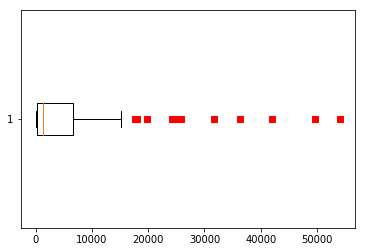

Summe:   687.663
Mean:      5.457


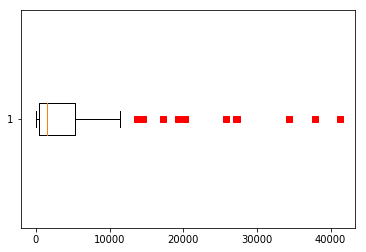

Summe:   578.718
Mean:      4.593


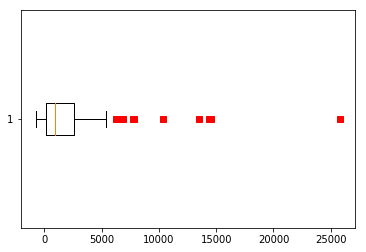

Summe:   268.323
Mean:      2.129


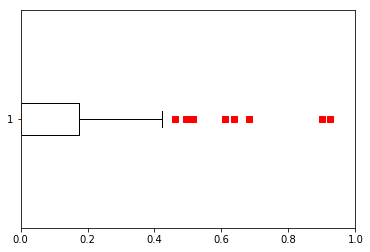

Mean:  12%


2016:          49.575
WiSe 16/17:    41.291 ┬   +13.476 (+48%)
WiSe 15/16:    27.815 ┘      


Wikipedia-Artikel: Analysis
Views WiSe 16/17:     44.740 ┬    -3.562 ( -7%)
Views WiSe 15/16:     48.302 ┘      

MFNF / Wikipedia – WiSe 16/17:  92%
MFNF / Wikipedia – WiSe 15/16:  58%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           7.708
WiSe 16/17:     4.425 ┬      +884 (+25%)
WiSe 15/16:     3.541 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           2.813
WiSe 16/17:     1.689 ┬      +128 ( +8%)
WiSe 15/16:     1.561 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           4.588
WiSe 16/17:     2.664 ┬       +68 ( +3%)
WiSe 15/16:     2.596 ┘      


Wikipedia-Artikel: Reelle Zahl
Views WiSe 16/17:    161.074 ┬    -4.599 ( -3%)
Views WiSe 15/16:    165.673 ┘      

MFNF / Wikipedia – WiSe 16/17:   2%
MFNF / Wikipedia – WiSe 15/16:   2%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           2.712
WiSe 16/17:     1.620 ┬      +732 (+82%)
WiSe 15/16:       888 ┘      


Wikipedia-Artikel: Zahlengerade
Views WiSe 16/17:      7.052 ┬      -896 (-11%)
Views WiSe 15/16:      7.948 ┘      

MFNF / Wikipedia – WiSe 16/17:  23%
MFNF / Wikipedia – WiSe 15/16:  11%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          15.147
WiSe 16/17:    10.795 ┬    +1.385 (+15%)
WiSe 15/16:     9.410 ┘      


Wikipedia-Artikel: Körper (Algebra)
Views WiSe 16/17:     51.184 ┬    -1.230 ( -2%)
Views WiSe 15/16:     52.414 ┘      

MFNF / Wikipedia – WiSe 16/17:  21%
MFNF / Wikipedia – WiSe 15/16:  18%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           9.486
WiSe 16/17:     8.067 ┬    +2.970 (+58%)
WiSe 15/16:     5.097 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           2.016
WiSe 16/17:     1.284 ┬      +124 (+11%)
WiSe 15/16:     1.160 ┘      


Wikipedia-Artikel: Potenz (Mathematik)
Views WiSe 16/17:    140.477 ┬    -2.395 ( -2%)
Views WiSe 15/16:    142.872 ┘      

MFNF / Wikipedia – WiSe 16/17:   1%
MFNF / Wikipedia – WiSe 15/16:   1%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           4.930
WiSe 16/17:     3.301 ┬      +465 (+16%)
WiSe 15/16:     2.836 ┘      


Wikipedia-Artikel: Geordneter Körper
Views WiSe 16/17:      6.665 ┬    -1.386 (-17%)
Views WiSe 15/16:      8.051 ┘      

MFNF / Wikipedia – WiSe 16/17:  50%
MFNF / Wikipedia – WiSe 15/16:  35%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           3.491
WiSe 16/17:     2.731 ┬      +740 (+37%)
WiSe 15/16:     1.991 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          12.340
WiSe 16/17:     9.170 ┬    +1.072 (+13%)
WiSe 15/16:     8.098 ┘      


Wikipedia-Artikel: Betragsfunktion
Views WiSe 16/17:     47.872 ┬    -5.609 (-10%)
Views WiSe 15/16:     53.481 ┘      

MFNF / Wikipedia – WiSe 16/17:  19%
MFNF / Wikipedia – WiSe 15/16:  15%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          13.053
WiSe 16/17:     7.586 ┬      -649 ( -8%)
WiSe 15/16:     8.235 ┘      


Wikipedia-Artikel: Intervall (Mathematik)
Views WiSe 16/17:     61.007 ┬      -894 ( -1%)
Views WiSe 15/16:     61.901 ┘      

MFNF / Wikipedia – WiSe 16/17:  12%
MFNF / Wikipedia – WiSe 15/16:  13%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           3.782
WiSe 16/17:     2.447 ┬       -84 ( -3%)
WiSe 15/16:     2.531 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           4.910
WiSe 16/17:     3.762 ┬      +455 (+14%)
WiSe 15/16:     3.307 ┘      


Wikipedia-Artikel: Archimedisches Axiom
Views WiSe 16/17:     10.932 ┬      -214 ( -2%)
Views WiSe 15/16:     11.146 ┘      

MFNF / Wikipedia – WiSe 16/17:  34%
MFNF / Wikipedia – WiSe 15/16:  30%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          11.303
WiSe 16/17:     9.386 ┬    +1.723 (+22%)
WiSe 15/16:     7.663 ┘      


Wikipedia-Artikel: Bernoullische Ungleichung
Views WiSe 16/17:     26.399 ┬    +2.006 ( +8%)
Views WiSe 15/16:     24.393 ┘      

MFNF / Wikipedia – WiSe 16/17:  36%
MFNF / Wikipedia – WiSe 15/16:  31%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           5.564
WiSe 16/17:     3.466 ┬      -305 ( -8%)
WiSe 15/16:     3.771 ┘      


Wikipedia-Artikel: Intervallschachtelung
Views WiSe 16/17:      8.216 ┬      -330 ( -4%)
Views WiSe 15/16:      8.546 ┘      

MFNF / Wikipedia – WiSe 16/17:  42%
MFNF / Wikipedia – WiSe 15/16:  44%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:        99 ┬       +99        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       126 ┬      +126        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       156 ┬      +156        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:        61 ┬       +61        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          19.797
WiSe 16/17:    14.515 ┬    +1.849 (+15%)
WiSe 15/16:    12.666 ┘      


Wikipedia-Artikel: Infimum und Supremum
Views WiSe 16/17:     34.592 ┬       +59 ( +0%)
Views WiSe 15/16:     34.533 ┘      

MFNF / Wikipedia – WiSe 16/17:  42%
MFNF / Wikipedia – WiSe 15/16:  37%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.344
WiSe 16/17:     1.273 ┬      +767 (+152%)
WiSe 15/16:       506 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          24.791
WiSe 16/17:    20.309 ┬    +6.247 (+44%)
WiSe 15/16:    14.062 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           6.716
WiSe 16/17:     5.297 ┬    +2.841 (+116%)
WiSe 15/16:     2.456 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           3.041
WiSe 16/17:     1.544 ┬      +703 (+84%)
WiSe 15/16:       841 ┘      


Wikipedia-Artikel: Wurzel (Mathematik)
Views WiSe 16/17:     95.389 ┬   -11.511 (-11%)
Views WiSe 15/16:    106.900 ┘      

MFNF / Wikipedia – WiSe 16/17:   2%
MFNF / Wikipedia – WiSe 15/16:   1%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             721
WiSe 16/17:       716 ┬      +716        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             638
WiSe 16/17:       605 ┬      +605        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             542
WiSe 16/17:       484 ┬      +484        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             562
WiSe 16/17:       409 ┬      +409        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          11.659
WiSe 16/17:     6.921 ┬      -752 (-10%)
WiSe 15/16:     7.673 ┘      


Wikipedia-Artikel: Folge (Mathematik)
Views WiSe 16/17:     41.058 ┬    -5.728 (-12%)
Views WiSe 15/16:     46.786 ┘      

MFNF / Wikipedia – WiSe 16/17:  17%
MFNF / Wikipedia – WiSe 15/16:  16%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          25.342
WiSe 16/17:    17.208 ┬    +6.627 (+63%)
WiSe 15/16:    10.581 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           7.286
WiSe 16/17:     6.855 ┬    +6.855        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.700
WiSe 16/17:     1.336 ┬      +380 (+40%)
WiSe 15/16:       956 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          54.130
WiSe 16/17:    37.836 ┬      +938 ( +3%)
WiSe 15/16:    36.898 ┘      


Wikipedia-Artikel: Grenzwert (Folge)
Views WiSe 16/17:     73.697 ┬    -8.429 (-10%)
Views WiSe 15/16:     82.126 ┘      

MFNF / Wikipedia – WiSe 16/17:  51%
MFNF / Wikipedia – WiSe 15/16:  45%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          41.986
WiSe 16/17:    34.355 ┬   +10.386 (+43%)
WiSe 15/16:    23.969 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          31.634
WiSe 16/17:    27.283 ┬   +14.347 (+111%)
WiSe 15/16:    12.936 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           4.018
WiSe 16/17:     3.173 ┬    +1.223 (+63%)
WiSe 15/16:     1.950 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          25.855
WiSe 16/17:    19.239 ┬    +6.591 (+52%)
WiSe 15/16:    12.648 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           7.184
WiSe 16/17:     6.101 ┬    +3.919 (+180%)
WiSe 15/16:     2.182 ┘      


Wikipedia-Artikel: Einschnürungssatz
Views WiSe 16/17:      6.767 ┬      -258 ( -4%)
Views WiSe 15/16:      7.025 ┘      

MFNF / Wikipedia – WiSe 16/17:  90%
MFNF / Wikipedia – WiSe 15/16:  31%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           4.987
WiSe 16/17:     4.293 ┬    +1.844 (+75%)
WiSe 15/16:     2.449 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           3.424
WiSe 16/17:     7.751 ┬    +7.751        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           2.082
WiSe 16/17:     2.294 ┬    +1.974 (+617%)
WiSe 15/16:       320 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          10.171
WiSe 16/17:     7.687 ┬    +2.170 (+39%)
WiSe 15/16:     5.517 ┘      


Wikipedia-Artikel: Teilfolge
Views WiSe 16/17:      5.430 ┬    -1.026 (-16%)
Views WiSe 15/16:      6.456 ┘      

MFNF / Wikipedia – WiSe 16/17: 142%
MFNF / Wikipedia – WiSe 15/16:  85%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          18.001
WiSe 16/17:    13.975 ┬    +4.087 (+41%)
WiSe 15/16:     9.888 ┘      


Wikipedia-Artikel: Häufungspunkt
Views WiSe 16/17:     20.508 ┬      +478 ( +2%)
Views WiSe 15/16:     20.030 ┘      

MFNF / Wikipedia – WiSe 16/17:  68%
MFNF / Wikipedia – WiSe 15/16:  49%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.902
WiSe 16/17:     3.147 ┬    +3.147        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           6.194
WiSe 16/17:     4.718 ┬    +2.205 (+88%)
WiSe 15/16:     2.513 ┘      


Wikipedia-Artikel: Satz von Bolzano-Weierstraß
Views WiSe 16/17:     15.293 ┬    +1.010 ( +7%)
Views WiSe 15/16:     14.283 ┘      

MFNF / Wikipedia – WiSe 16/17:  31%
MFNF / Wikipedia – WiSe 15/16:  18%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           2.179
WiSe 16/17:     2.879 ┬    +2.717 (+1677%)
WiSe 15/16:       162 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             933
WiSe 16/17:       693 ┬      +693        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          12.690
WiSe 16/17:    11.365 ┬    +5.419 (+91%)
WiSe 15/16:     5.946 ┘      


Wikipedia-Artikel: Limes superior und Limes inferior
Views WiSe 16/17:     22.790 ┬    -1.996 ( -8%)
Views WiSe 15/16:     24.786 ┘      

MFNF / Wikipedia – WiSe 16/17:  50%
MFNF / Wikipedia – WiSe 15/16:  24%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          17.655
WiSe 16/17:    13.765 ┬    +4.353 (+46%)
WiSe 15/16:     9.412 ┘      


Wikipedia-Artikel: Cauchy-Folge
Views WiSe 16/17:     21.587 ┬    -2.754 (-11%)
Views WiSe 15/16:     24.341 ┘      

MFNF / Wikipedia – WiSe 16/17:  64%
MFNF / Wikipedia – WiSe 15/16:  39%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             831
WiSe 16/17:       899 ┬      +856 (+1991%)
WiSe 15/16:        43 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          13.488
WiSe 16/17:     7.958 ┬      -555 ( -7%)
WiSe 15/16:     8.513 ┘      


Wikipedia-Artikel: Reihe (Mathematik)
Views WiSe 16/17:     51.825 ┬    -6.599 (-11%)
Views WiSe 15/16:     58.424 ┘      

MFNF / Wikipedia – WiSe 16/17:  15%
MFNF / Wikipedia – WiSe 15/16:  15%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           2.401
WiSe 16/17:     2.767 ┬    +2.633 (+1965%)
WiSe 15/16:       134 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           8.488
WiSe 16/17:     7.160 ┬    +3.423 (+92%)
WiSe 15/16:     3.737 ┘      


Wikipedia-Artikel: Teleskopsumme
Views WiSe 16/17:     11.720 ┬       -99 ( -1%)
Views WiSe 15/16:     11.819 ┘      

MFNF / Wikipedia – WiSe 16/17:  61%
MFNF / Wikipedia – WiSe 15/16:  32%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          36.382
WiSe 16/17:    27.096 ┬   +14.588 (+117%)
WiSe 15/16:    12.508 ┘      


Wikipedia-Artikel: Geometrische Reihe
Views WiSe 16/17:    137.612 ┬    -3.263 ( -2%)
Views WiSe 15/16:    140.875 ┘      

MFNF / Wikipedia – WiSe 16/17:  20%
MFNF / Wikipedia – WiSe 15/16:   9%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           8.258
WiSe 16/17:     8.983 ┬    +7.843 (+688%)
WiSe 15/16:     1.140 ┘      


Wikipedia-Artikel: Harmonische Reihe
Views WiSe 16/17:     50.362 ┬    -4.903 ( -9%)
Views WiSe 15/16:     55.265 ┘      

MFNF / Wikipedia – WiSe 16/17:  18%
MFNF / Wikipedia – WiSe 15/16:   2%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             715
WiSe 16/17:       939 ┬      +939        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           8.085
WiSe 16/17:     6.469 ┬    +3.862 (+148%)
WiSe 15/16:     2.607 ┘      


Wikipedia-Artikel: Absolute Konvergenz
Views WiSe 16/17:     13.981 ┬    -2.037 (-13%)
Views WiSe 15/16:     16.018 ┘      

MFNF / Wikipedia – WiSe 16/17:  46%
MFNF / Wikipedia – WiSe 15/16:  16%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.082
WiSe 16/17:     1.530 ┬    +1.530        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Umordnung von Reihen
Views WiSe 16/17:      2.500 ┬      -722 (-22%)
Views WiSe 15/16:      3.222 ┘      

MFNF / Wikipedia – WiSe 16/17:  61%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.498
WiSe 16/17:     1.252 ┬      +988 (+374%)
WiSe 15/16:       264 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          24.166
WiSe 16/17:    25.825 ┬   +25.825        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Konvergenzkriterium
Views WiSe 16/17:     24.558 ┬    -4.703 (-16%)
Views WiSe 15/16:     29.261 ┘      

MFNF / Wikipedia – WiSe 16/17: 105%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           6.609
WiSe 16/17:     5.295 ┬    +2.329 (+79%)
WiSe 15/16:     2.966 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.493
WiSe 16/17:     1.578 ┬    +1.467 (+1322%)
WiSe 15/16:       111 ┘      


Wikipedia-Artikel: Nullfolgenkriterium
Views WiSe 16/17:      8.195 ┬    -1.211 (-13%)
Views WiSe 15/16:      9.406 ┘      

MFNF / Wikipedia – WiSe 16/17:  19%
MFNF / Wikipedia – WiSe 15/16:   1%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.228
WiSe 16/17:     1.765 ┬    +1.651 (+1448%)
WiSe 15/16:       114 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          11.130
WiSe 16/17:     9.243 ┬    +6.725 (+267%)
WiSe 15/16:     2.518 ┘      


Wikipedia-Artikel: Majorantenkriterium
Views WiSe 16/17:     17.995 ┬    -4.164 (-19%)
Views WiSe 15/16:     22.159 ┘      

MFNF / Wikipedia – WiSe 16/17:  51%
MFNF / Wikipedia – WiSe 15/16:  11%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           7.042
WiSe 16/17:     5.684 ┬    +4.476 (+371%)
WiSe 15/16:     1.208 ┘      


Wikipedia-Artikel: Wurzelkriterium
Views WiSe 16/17:     19.544 ┬    -1.587 ( -8%)
Views WiSe 15/16:     21.131 ┘      

MFNF / Wikipedia – WiSe 16/17:  29%
MFNF / Wikipedia – WiSe 15/16:   6%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           8.885
WiSe 16/17:     7.667 ┬    +6.576 (+603%)
WiSe 15/16:     1.091 ┘      


Wikipedia-Artikel: Quotientenkriterium
Views WiSe 16/17:     29.066 ┬    -2.143 ( -7%)
Views WiSe 15/16:     31.209 ┘      

MFNF / Wikipedia – WiSe 16/17:  26%
MFNF / Wikipedia – WiSe 15/16:   3%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           4.456
WiSe 16/17:     5.367 ┬    +4.836 (+911%)
WiSe 15/16:       531 ┘      


Wikipedia-Artikel: Leibniz-Kriterium
Views WiSe 16/17:     25.582 ┬    -1.764 ( -6%)
Views WiSe 15/16:     27.346 ┘      

MFNF / Wikipedia – WiSe 16/17:  21%
MFNF / Wikipedia – WiSe 15/16:   2%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.586
WiSe 16/17:     2.235 ┬    +2.126 (+1950%)
WiSe 15/16:       109 ┘      


Wikipedia-Artikel: Cauchysches Verdichtungskriterium
Views WiSe 16/17:      7.202 ┬    -2.167 (-23%)
Views WiSe 15/16:      9.369 ┘      

MFNF / Wikipedia – WiSe 16/17:  31%
MFNF / Wikipedia – WiSe 15/16:   1%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       390 ┬      +390        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.149
WiSe 16/17:     1.430 ┬    +1.249 (+690%)
WiSe 15/16:       181 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             695
WiSe 16/17:     1.470 ┬    +1.470        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Exponentialfunktion
Views WiSe 16/17:    208.851 ┬    -6.792 ( -3%)
Views WiSe 15/16:    215.643 ┘      

MFNF / Wikipedia – WiSe 16/17:   1%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       144 ┬      +144        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:        94 ┬       +94        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Logarithmus
Views WiSe 16/17:    297.472 ┬   -29.695 ( -9%)
Views WiSe 15/16:    327.167 ┘      

MFNF / Wikipedia – WiSe 16/17:   0%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:        29 ┬       +29        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:        28 ┬       +28        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       462 ┬      +462        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Sinus und Kosinus
Views WiSe 16/17:    434.451 ┬   -19.133 ( -4%)
Views WiSe 15/16:    453.584 ┘      

MFNF / Wikipedia – WiSe 16/17:   0%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       240 ┬      +240        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       176 ┬      +176        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Arkussinus und Arkuskosinus
Views WiSe 16/17:     81.694 ┬    -2.818 ( -3%)
Views WiSe 15/16:     84.512 ┘      

MFNF / Wikipedia – WiSe 16/17:   0%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Tangens und Kotangens
Views WiSe 16/17:    205.480 ┬    +2.521 ( +1%)
Views WiSe 15/16:    202.959 ┘      

MFNF / Wikipedia – WiSe 16/17:   0%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:        58 ┬       +58        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Arkustangens und Arkuskotangens
Views WiSe 16/17:     94.338 ┬    +2.272 ( +2%)
Views WiSe 15/16:     92.066 ┘      

MFNF / Wikipedia – WiSe 16/17:   0%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:        79 ┬       +79        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Sinus Hyperbolicus und Kosinus Hyperbolicus
Views WiSe 16/17:     85.196 ┬    +1.353 ( +2%)
Views WiSe 15/16:     83.843 ┘      

MFNF / Wikipedia – WiSe 16/17:   0%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:        56 ┬       +56        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:          11.261
WiSe 16/17:     9.531 ┬    +5.158 (+118%)
WiSe 15/16:     4.373 ┘      


Wikipedia-Artikel: Stetigkeit
Views WiSe 16/17:     77.323 ┬    -8.292 (-10%)
Views WiSe 15/16:     85.615 ┘      

MFNF / Wikipedia – WiSe 16/17:  12%
MFNF / Wikipedia – WiSe 15/16:   5%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           2.111
WiSe 16/17:     4.303 ┬    +4.303        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       141 ┬      +141        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             420
WiSe 16/17:       916 ┬      +916        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Grenzwert (Funktion)
Views WiSe 16/17:     51.406 ┬    -8.926 (-15%)
Views WiSe 15/16:     60.332 ┘      

MFNF / Wikipedia – WiSe 16/17:   2%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           2.317
WiSe 16/17:     2.825 ┬    +2.396 (+559%)
WiSe 15/16:       429 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       129 ┬      +129        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       114 ┬      +114        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.348
WiSe 16/17:     3.610 ┬    +3.610        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Zwischenwertsatz
Views WiSe 16/17:     18.349 ┬    -2.351 (-11%)
Views WiSe 15/16:     20.700 ┘      

MFNF / Wikipedia – WiSe 16/17:  20%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             951
WiSe 16/17:     1.963 ┬    +1.963        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Satz vom Minimum und Maximum
Views WiSe 16/17:      5.578 ┬    +2.780 (+99%)
Views WiSe 15/16:      2.798 ┘      

MFNF / Wikipedia – WiSe 16/17:  35%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             535
WiSe 16/17:     1.156 ┬    +1.156        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             616
WiSe 16/17:     2.746 ┬    +2.746        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Gleichmäßige Stetigkeit
Views WiSe 16/17:     15.515 ┬    -1.930 (-11%)
Views WiSe 15/16:     17.445 ┘      

MFNF / Wikipedia – WiSe 16/17:  18%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       315 ┬      +315        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Lipschitz-Stetigkeit
Views WiSe 16/17:     29.820 ┬       +36 ( +0%)
Views WiSe 15/16:     29.784 ┘      

MFNF / Wikipedia – WiSe 16/17:   1%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.444
WiSe 16/17:     1.427 ┬      +640 (+81%)
WiSe 15/16:       787 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.872
WiSe 16/17:     2.617 ┬    +2.617        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Differentialrechnung
Views WiSe 16/17:    136.137 ┬   -11.521 ( -8%)
Views WiSe 15/16:    147.658 ┘      

MFNF / Wikipedia – WiSe 16/17:   2%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.586
WiSe 16/17:     1.241 ┬    +1.241        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             761
WiSe 16/17:       932 ┬      +932        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             848
WiSe 16/17:       676 ┬      +676        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             619
WiSe 16/17:       735 ┬      +735        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.217
WiSe 16/17:     1.827 ┬    +1.827        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Satz von Rolle
Views WiSe 16/17:      7.960 ┬      -367 ( -4%)
Views WiSe 15/16:      8.327 ┘      

MFNF / Wikipedia – WiSe 16/17:  23%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             995
WiSe 16/17:     3.010 ┬    +3.010        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Mittelwertsatz der Differentialrechnung
Views WiSe 16/17:     32.246 ┬      +227 ( +1%)
Views WiSe 15/16:     32.019 ┘      

MFNF / Wikipedia – WiSe 16/17:   9%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             591
WiSe 16/17:       790 ┬      +790        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.008
WiSe 16/17:     1.489 ┬    +1.489        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Extremwert
Views WiSe 16/17:     33.113 ┬    -7.007 (-17%)
Views WiSe 15/16:     40.120 ┘      

MFNF / Wikipedia – WiSe 16/17:   4%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             879
WiSe 16/17:     1.451 ┬    +1.451        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             276
WiSe 16/17:       744 ┬      +744        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             262
WiSe 16/17:       470 ┬      +470        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             196
WiSe 16/17:       374 ┬      +374        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             284
WiSe 16/17:       457 ┬      +457        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             711
WiSe 16/17:       971 ┬      +971        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Integralrechnung
Views WiSe 16/17:    145.721 ┬   -26.017 (-15%)
Views WiSe 15/16:    171.738 ┘      

MFNF / Wikipedia – WiSe 16/17:   1%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.235
WiSe 16/17:     1.905 ┬    +1.905        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Riemannsches Integral
Views WiSe 16/17:     25.871 ┬      +654 ( +3%)
Views WiSe 15/16:     25.217 ┘      

MFNF / Wikipedia – WiSe 16/17:   7%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:              38
WiSe 16/17:       249 ┬      +249        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       306 ┬      +306        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               4
WiSe 16/17:        65 ┬       +65        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Mittelwertsatz der Integralrechnung
Views WiSe 16/17:     13.428 ┬       -75 ( -1%)
Views WiSe 15/16:     13.503 ┘      

MFNF / Wikipedia – WiSe 16/17:   0%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             350
WiSe 16/17:       946 ┬      +946        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Fundamentalsatz der Analysis
Views WiSe 16/17:     21.884 ┬      +606 ( +3%)
Views WiSe 15/16:     21.278 ┘      

MFNF / Wikipedia – WiSe 16/17:   4%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             407
WiSe 16/17:     1.073 ┬    +1.073        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Integration durch Substitution
Views WiSe 16/17:     49.679 ┬    -8.854 (-15%)
Views WiSe 15/16:     58.533 ┘      

MFNF / Wikipedia – WiSe 16/17:   2%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             272
WiSe 16/17:       633 ┬      +633        
WiSe 15/16:         0 ┘      


Wikipedia-Artikel: Partielle Integration
Views WiSe 16/17:    113.387 ┬   -11.171 ( -9%)
Views WiSe 15/16:    124.558 ┘      

MFNF / Wikipedia – WiSe 16/17:   1%
MFNF / Wikipedia – WiSe 15/16:   0%


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:        61 ┬       +61        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

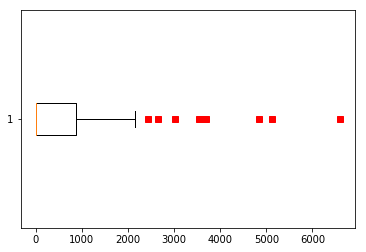

Summe:    46.717
Mean:        805


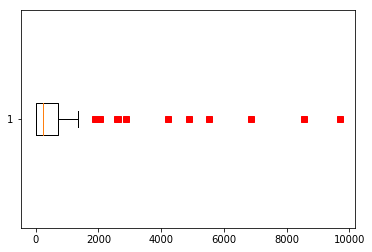

Summe:    63.092
Mean:      1.087


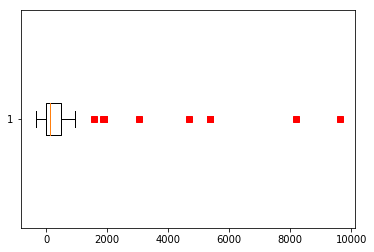

Summe:    50.438
Mean:        869


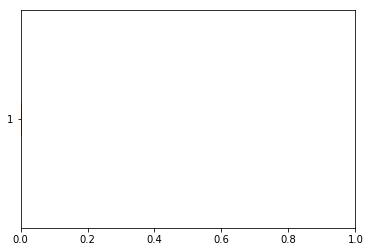

Mean:   0%


2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.248
WiSe 16/17:     2.582 ┬    +1.556 (+152%)
WiSe 15/16:     1.026 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             875
WiSe 16/17:       728 ┬      -222 (-23%)
WiSe 15/16:       950 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             407
WiSe 16/17:       285 ┬       +14 ( +5%)
WiSe 15/16:       271 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             308
WiSe 16/17:       293 ┬      +144 (+97%)
WiSe 15/16:       149 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             357
WiSe 16/17:       334 ┬       +41 (+14%)
WiSe 15/16:       293 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           5.130
WiSe 16/17:     2.880 ┬      +614 (+27%)
WiSe 15/16:     2.266 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           2.433
WiSe 16/17:     1.017 ┬      -339 (-25%)
WiSe 15/16:     1.356 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       170 ┬      +170        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.160
WiSe 16/17:       521 ┬       -64 (-11%)
WiSe 15/16:       585 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             367
WiSe 16/17:       690 ┬      +690        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             303
WiSe 16/17:       292 ┬      +216 (+284%)
WiSe 15/16:        76 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             390
WiSe 16/17:       344 ┬      +241 (+234%)
WiSe 15/16:       103 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           6.601
WiSe 16/17:     6.869 ┬    +5.373 (+359%)
WiSe 15/16:     1.496 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           3.606
WiSe 16/17:     4.902 ┬    +4.697 (+2291%)
WiSe 15/16:       205 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             846
WiSe 16/17:     1.896 ┬    +1.896        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           4.839
WiSe 16/17:     4.225 ┬    +3.041 (+257%)
WiSe 15/16:     1.184 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           2.644
WiSe 16/17:     2.620 ┬    +1.862 (+246%)
WiSe 15/16:       758 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           2.154
WiSe 16/17:     1.343 ┬      +495 (+58%)
WiSe 15/16:       848 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           3.701
WiSe 16/17:     5.538 ┬    +5.365 (+3101%)
WiSe 15/16:       173 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       227 ┬      +227        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               1
WiSe 16/17:       949 ┬      +948 (+94800%)
WiSe 15/16:         1 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       344 ┬      +344        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       107 ┬      +107        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       212 ┬      +212        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             275
WiSe 16/17:       309 ┬      +309        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       116 ┬      +116        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       110 ┬      +110        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:        40 ┬       +40        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       703 ┬      +703        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:        71 ┬       +71        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       207 ┬      +207        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       155 ┬      +155        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:        50 ┬       +50        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           3.015
WiSe 16/17:     8.552 ┬    +8.202 (+2343%)
WiSe 15/16:       350 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           3.536
WiSe 16/17:     9.712 ┬    +9.634 (+12351%)
WiSe 15/16:        78 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             898
WiSe 16/17:       391 ┬      +208 (+114%)
WiSe 15/16:       183 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             567
WiSe 16/17:       559 ┬      +415 (+288%)
WiSe 15/16:       144 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.056
WiSe 16/17:     2.059 ┬    +1.900 (+1195%)
WiSe 15/16:       159 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       201 ┬      +201        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       489 ┬      +489        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

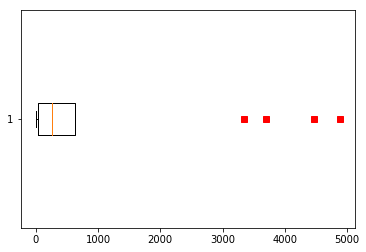

Summe:    19.052
Mean:      1.120


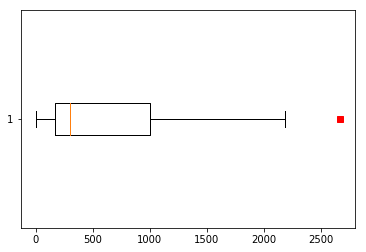

Summe:    12.469
Mean:        733


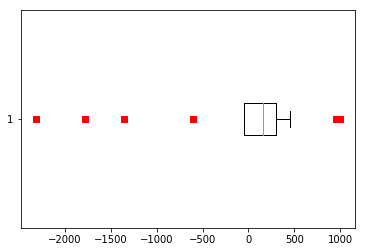

Summe:    -2.265
Mean:       -133


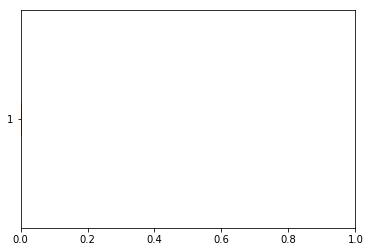

Mean:   0%


2016:           4.889
WiSe 16/17:     2.190 ┬    -1.362 (-38%)
WiSe 15/16:     3.552 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             469
WiSe 16/17:       232 ┬       -44 (-16%)
WiSe 15/16:       276 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             268
WiSe 16/17:       243 ┬      +243        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             623
WiSe 16/17:     1.000 ┬    +1.000        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             393
WiSe 16/17:       369 ┬      +326 (+758%)
WiSe 15/16:        43 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:              70
WiSe 16/17:       240 ┬      +240        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:              35
WiSe 16/17:       164 ┬      +164        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             163
WiSe 16/17:       449 ┬      +449        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:       170 ┬      +170        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           3.352
WiSe 16/17:     1.674 ┬    -1.777 (-51%)
WiSe 15/16:     3.451 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           3.695
WiSe 16/17:     1.814 ┬    -2.319 (-56%)
WiSe 15/16:     4.133 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           4.472
WiSe 16/17:     2.671 ┬      -608 (-19%)
WiSe 15/16:     3.279 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             475
WiSe 16/17:       957 ┬      +957        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             148
WiSe 16/17:       296 ┬      +296        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

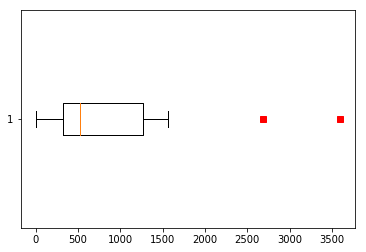

Summe:    16.771
Mean:        882


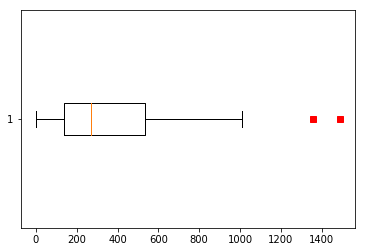

Summe:     8.202
Mean:        431


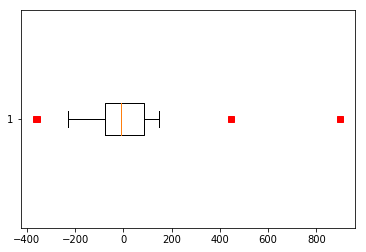

Summe:       519
Mean:         27


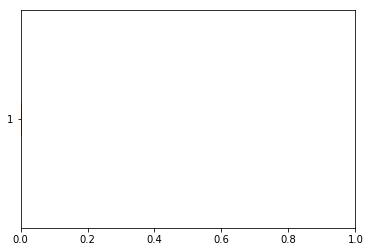

Mean:   0%


2016:           2.687
WiSe 16/17:     1.355 ┬       -75 ( -5%)
WiSe 15/16:     1.430 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.269
WiSe 16/17:       621 ┬       -59 ( -9%)
WiSe 15/16:       680 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             468
WiSe 16/17:       236 ┬      +148 (+168%)
WiSe 15/16:        88 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.056
WiSe 16/17:       425 ┬       -64 (-13%)
WiSe 15/16:       489 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.258
WiSe 16/17:       706 ┬       -77 (-10%)
WiSe 15/16:       783 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             318
WiSe 16/17:       149 ┬       +22 (+17%)
WiSe 15/16:       127 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             324
WiSe 16/17:       132 ┬       -47 (-26%)
WiSe 15/16:       179 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             526
WiSe 16/17:       271 ┬        -8 ( -3%)
WiSe 15/16:       279 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             209
WiSe 16/17:        98 ┬       +51 (+109%)
WiSe 15/16:        47 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             560
WiSe 16/17:       319 ┬      +138 (+76%)
WiSe 15/16:       181 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             517
WiSe 16/17:       445 ┬      +445        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             557
WiSe 16/17:       212 ┬      -230 (-52%)
WiSe 15/16:       442 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             391
WiSe 16/17:       133 ┬       -73 (-35%)
WiSe 15/16:       206 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.561
WiSe 16/17:       407 ┬      -357 (-47%)
WiSe 15/16:       764 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           3.597
WiSe 16/17:     1.490 ┬      -363 (-20%)
WiSe 15/16:     1.853 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:           1.277
WiSe 16/17:     1.011 ┬      +899 (+803%)
WiSe 15/16:       112 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:        46 ┬       +46        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:               0
WiSe 16/17:         0 ┬        +0        
WiSe 15/16:         0 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

2016:             196
WiSe 16/17:       146 ┬      +123 (+535%)
WiSe 15/16:        23 ┘      


[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)

In [21]:
def report(node, level=1):
    h(("=" * level) + " " + node["name"] +  " " + ("=" * level), level,hid=node["name"])
    
    if len(node["children"]) > 0 and level <= 2:
        h("Artikel + Unterartikel: Seitenaufrufe 2016", 6)
        v2016 = collect(views_2016, node)
        plt.boxplot(v2016, 0, "rs", 0)
        plt.show()
        
        print("Summe: %s" % d(sum(v2016)))
        print("Mean:  %s" % d(np.mean(v2016)))
        
        h("Artikel + Unterartikel: Seitenaufrufe WiSe 2016/17", 6)
        w16 = collect(views_ws16, node)
        plt.boxplot(w16, 0, "rs", 0)
        plt.show()
        
        print("Summe: %s" % d(sum(w16)))
        print("Mean:  %s" % d(np.mean(w16)))
        
        h("Artikel + Unterartikel: Differenz Seitenaufrufe WiSe 2016/17 zu WiSe 2015/16", 6)
        w16d = collect(ws16_diff, node)
        plt.boxplot(w16d, 0, "rs", 0)
        plt.show()
        
        print("Summe: %s" % d(sum(w16d)))
        print("Mean:  %s" % d(np.mean(w16d)))
        
        h("Artikel + Unterartikel: Quotient Seitenaufrufe MFNF / Wikipedia", 6)
        w16d = collect(wp_ws16_quot, node)
        plt.boxplot(w16d, 0, "rs", 0)
        plt.xlim((0,1))
        plt.show()
        
        print("Mean: %3.0f%%" % (100*np.mean(w16d)))
    
    if "link" in node and node["link"]:
        h("Seitenaufrufe Artikel", 5)
        
        v2016 = views_2016(node)
        
        w16 = views_ws16(node)
        w15 = views_ws15(node)
        
        print("2016:       %s" % d(v2016))
        print("WiSe 16/17: %s ┬ %s %s" % (d(w16), diff(w16,w15), quot(w16,w15)))
        print("WiSe 15/16: %s ┘      " %  d(w15))
        
        w = wp_title(node)
        
        if w:
            h("Vergleich der Seitenaufrufe zum Wikipedia-Artikel", 5)
            
            wp16 = wp_ws16(node)
            wp15 = wp_ws15(node)
            
            print("Wikipedia-Artikel: %s" % w)
            print("Views WiSe 16/17:  %s ┬ %s %s" % (d(wp16), diff(wp16,wp15), quot(wp16,wp15)))
            print("Views WiSe 15/16:  %s ┘      " %  d(wp15))
            print()
            print("MFNF / Wikipedia – WiSe 16/17: %3.0f%%" % (wp_ws16_quot(node)*100))
            print("MFNF / Wikipedia – WiSe 15/16: %3.0f%%" % (wp_ws15_quot(node)*100))
    
    display_markdown("[Zurück zum Inhaltsverzeichnis](#Inhaltsverzeichnis)")
    
    for child in node["children"]:
        report(child, level+1)

report(sitemap)